In [1]:
import pandas as pd
import numpy as np
import env
import matplotlib.pyplot as plt
import seaborn as sns

# custom module imports
from acquire import acquire_zillow_data
from prepare import remove_outliers, prepare_zillow
from wrangle import wrangle_zillow

# feature selection imports
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split

# import scaling methods
from sklearn.preprocessing import MinMaxScaler, RobustScaler, StandardScaler, QuantileTransformer
from scipy import stats

# import modeling methods
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import explained_variance_score

# import to remove warnings
import warnings
warnings.filterwarnings("ignore")


In [2]:
train, validate, test, X_train, y_train, X_validate, y_validate, X_test, y_test = wrangle_zillow('tax_value')

Using cached CSV
Undergoing preparatory stage: 

199 null values removed. 
 52,319 rows remain.
 
Yearbuilt converted to age. 

 Federal Information Processing Standard Publication (FIPS) 
 reveals this Zillow data deals with three counties: 
 Los Angeles (06037), Orange (06059), and Ventura (06111). 
 Hence, data pertains only to Southern California. 

Outliers removed individually on a county-by-county basis. 
 County data recombined accordingly. 
 DF row-based percentage loss after outlier eradication: 19.13%. 

(23524, 7) (10082, 7) (8402, 7)


Please note that this notebook was created after initial_report.ipynb. Much of that notebook was itself a form of exploration. After careful consideration among the many scalers I attempted to use there, despite the seemingly weaker correlations as a result of my initial exploration, I have opted to stick to my original route of min_max scaling based on steps taken in preparation. Preparatory feats can be seen in workbook.ipynb, although my bad habit of going back and changing lines and cells versus proceeding has effectivley shifted around the order for much of that. I will try to be as clear as possible in this notebook. 

In [3]:
def scale_data(X_train, X_validate, X_test, return_scaler=False):
    '''
    Scales the 3 data splits.
    
    takes in the train, validate, and test data splits and returns their scaled counterparts.
    
    If return_scaler is true, the scaler object will be returned as well.
    
    Target is not scaled.
    
    columns_to_scale was originally used to check whether los_angeles and orange would cause trouble
    '''
    columns_to_scale = ['beds', 'baths', 'area', 'age', 'los_angeles', 'orange']
    
    X_train_scaled = X_train.copy()
    X_validate_scaled = X_validate.copy()
    X_test_scaled = X_test.copy()
    
    scaler = MinMaxScaler()
    scaler.fit(X_train_scaled[columns_to_scale])
    
    X_train_scaled[columns_to_scale] = scaler.transform(X_train[columns_to_scale])
    X_validate_scaled[columns_to_scale] = scaler.transform(X_validate[columns_to_scale])
    X_test_scaled[columns_to_scale] = scaler.transform(X_test[columns_to_scale])
    
    if return_scaler:
        return scaler, X_train_scaled, X_validate_scaled, X_test_scaled
    else:
        return X_train_scaled, X_validate_scaled, X_test_scaled

In [4]:
X_train_scaled, X_validate_scaled, X_test_scaled = scale_data(X_train, X_validate, X_test)

Text(0.5, 1.0, 'Scaled')

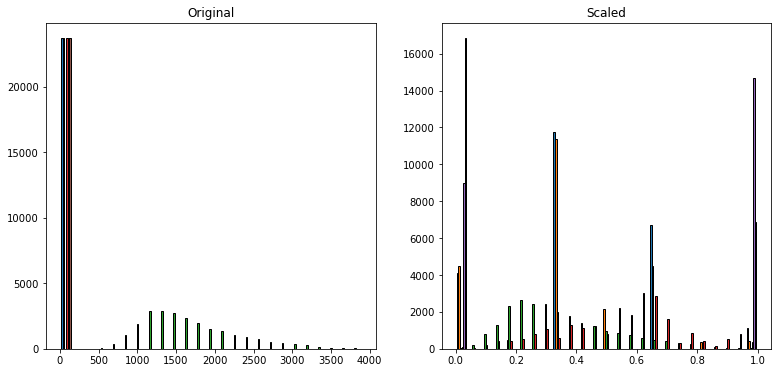

In [5]:
plt.figure(figsize=(13, 6))
plt.subplot(121)
plt.hist(X_train, bins=25, ec='black')
plt.title('Original')
plt.subplot(122)
plt.hist(X_train_scaled, bins=25, ec='black')
plt.title('Scaled')

In [19]:
# Univariates have already been beaten to death. Now I am looking at pairs. 
def plot_categorical_and_continuous_vars(categorical_var, continuous_var, df):
    """
    Accepts a string name of a categorical variable, 
    a string name from a continuous variable and their dataframe
    then it displays 4 different plots.
    """
   # fig, axes = plt.subplots(2, 2, sharex=False, figsize=(10, 12))
    
    #plt.subplot(131)
    plt.suptitle(f'{continuous_var} by {categorical_var}', fontsize=18)
    
    sns.lineplot(x=categorical_var, y=continuous_var, data=df)
    plt.xlabel(categorical_var, fontsize=12)
    plt.ylabel(continuous_var, fontsize=12)
    
   # plt.subplot(132)
    sns.catplot(x=categorical_var, y=continuous_var, data=df, kind='box', palette='deep')
    plt.xlabel(categorical_var, fontsize=12)
    plt.ylabel(continuous_var, fontsize=12)
    
   # plt.subplot(134)
    sns.catplot(x=categorical_var, y=continuous_var, data=df, kind='bar', palette='dark')
    plt.xlabel(categorical_var, fontsize=12)
    plt.ylabel(continuous_var, fontsize=12)
    
    plt.show()

In [21]:
train_scaled_df = pd.concat([X_train_scaled, y_train], axis=1)

In [22]:
train_scaled_df

,beds,baths,area,age,los_angeles,orange,tax_value
49512,0.333333,0.333333,0.205788,0.958333,1.0,0.0,746758.0
50882,0.000000,0.333333,0.322713,0.708333,1.0,0.0,687000.0
40257,0.666667,0.500000,0.763519,0.385417,0.0,1.0,1090406.0
4322,0.333333,0.333333,0.242327,0.385417,1.0,0.0,582854.0
19181,0.000000,0.333333,0.172757,0.177083,0.0,1.0,284057.0
...,...,...,...,...,...,...,...
30421,0.666667,0.333333,0.321543,0.531250,0.0,1.0,629000.0
48851,0.333333,0.333333,0.269804,0.531250,1.0,0.0,394200.0
26486,0.666667,0.333333,0.251681,0.666667,1.0,0.0,293905.0
15247,0.666667,0.833333,0.964923,0.260417,0.0,1.0,1085000.0


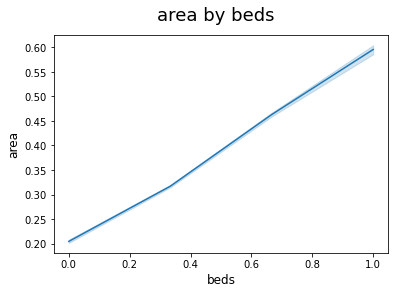

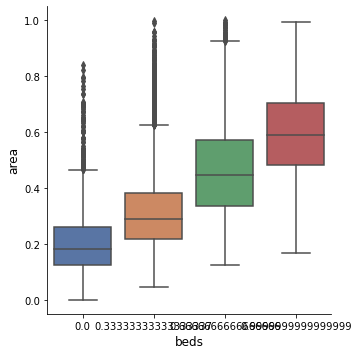

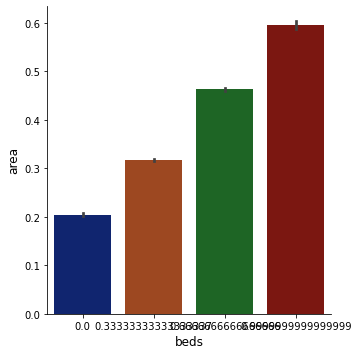

In [23]:
plot_categorical_and_continuous_vars('beds', 'area', train_scaled_df)

In [24]:
# looking at scaled will annoy me. So will going through one at a time. 

# populate the list of numeric attributes and categorical attributes

num_list = []
cat_list = []

for column in train: 
    if pd.api.types.is_numeric_dtype(train[column]):
        num_list.append(column)
    elif pd.api.types.is_string_dtype(train[column]):
        cat_list.append(column)
        
print(num_list)
print(cat_list)

# so everything is listed as quantitative. Effectively counties really are categories,
# but since they're encoded, I can't see them as that. So, I will have to manually check it that way first. 

['beds', 'baths', 'area', 'tax_value', 'age', 'los_angeles', 'orange']
[]


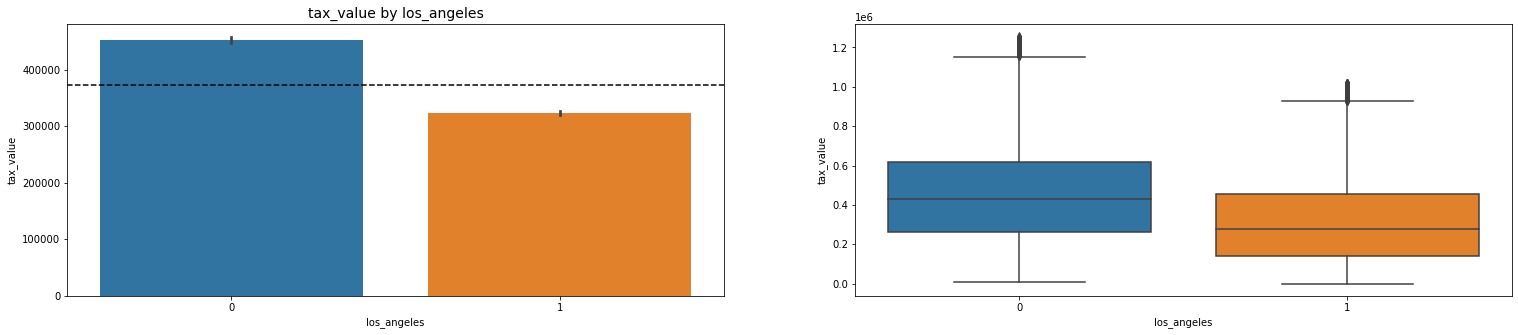

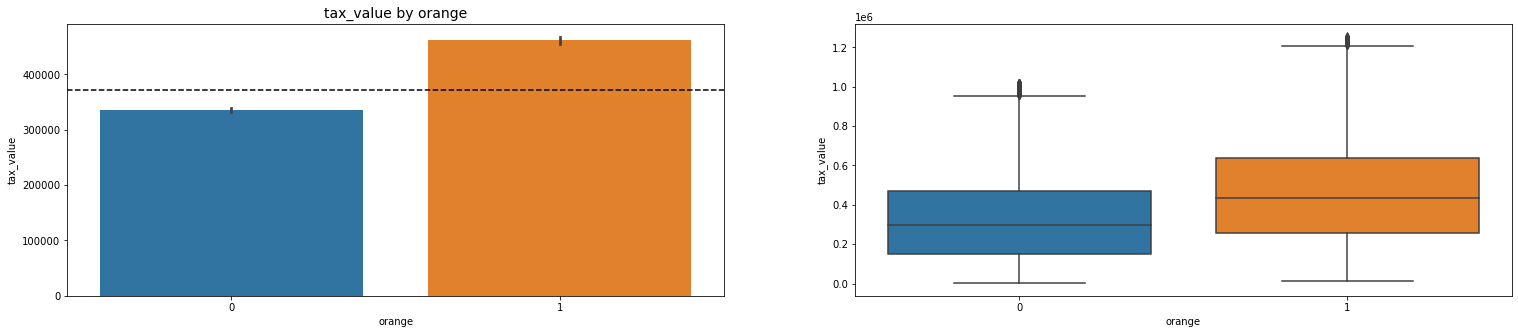

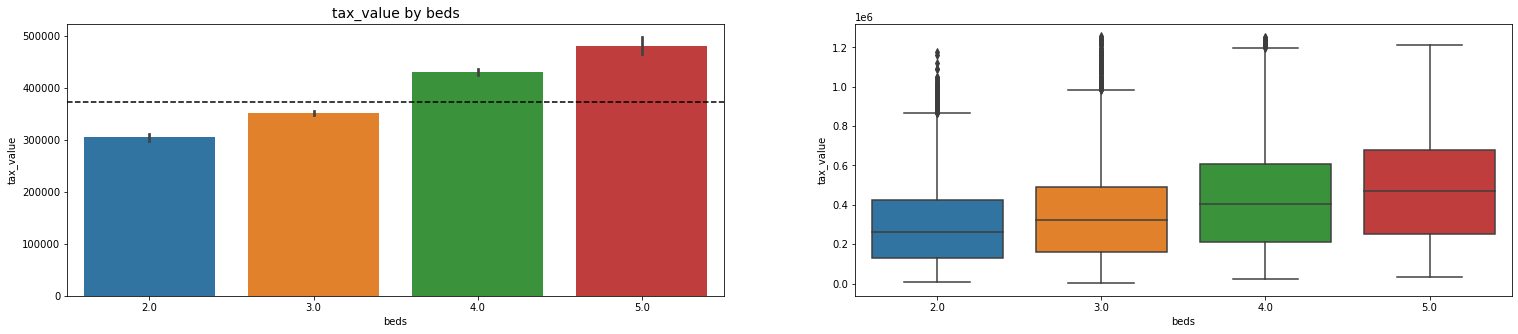

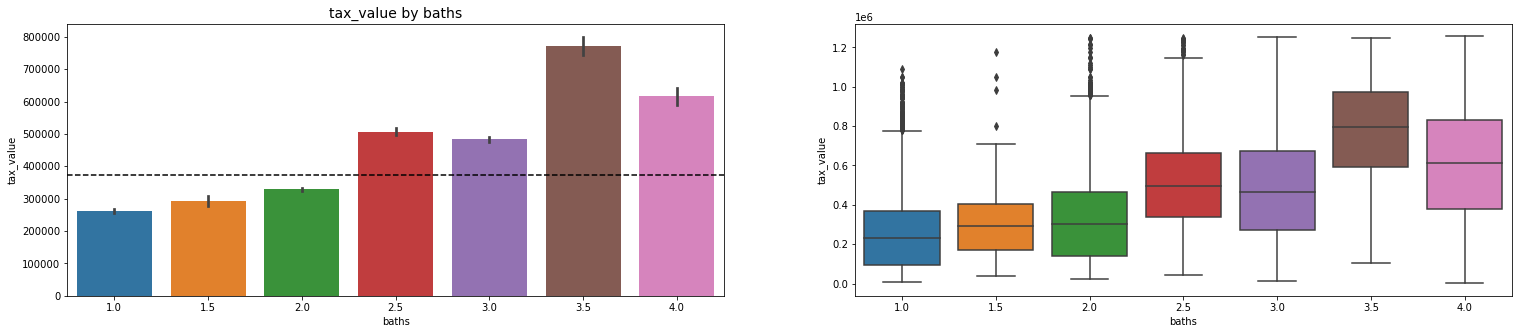

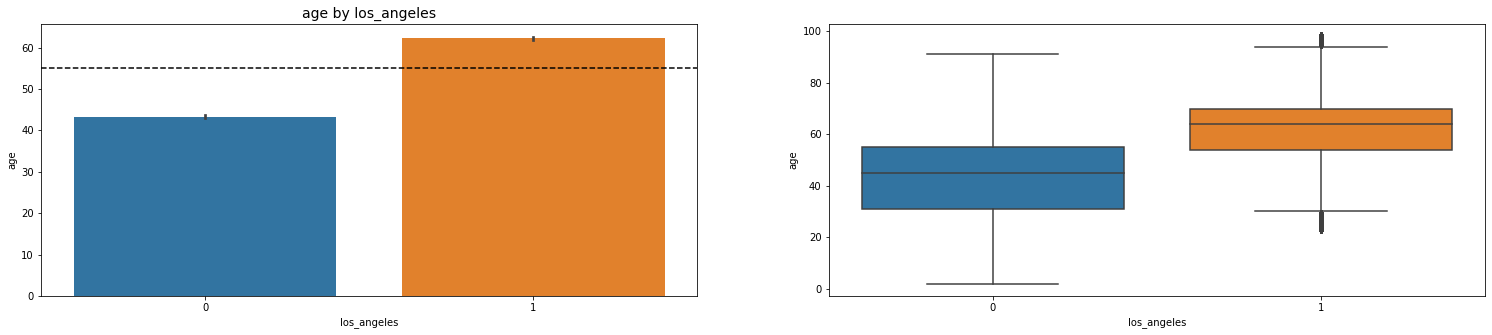

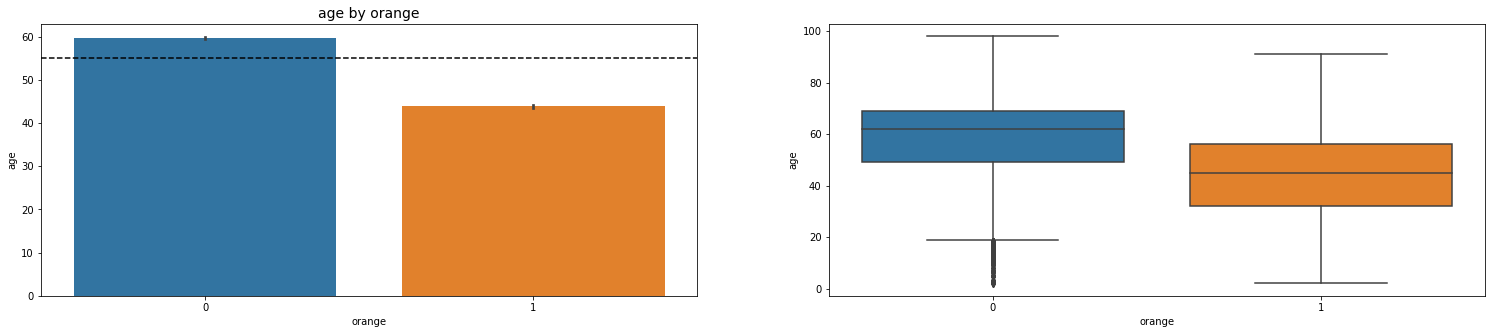

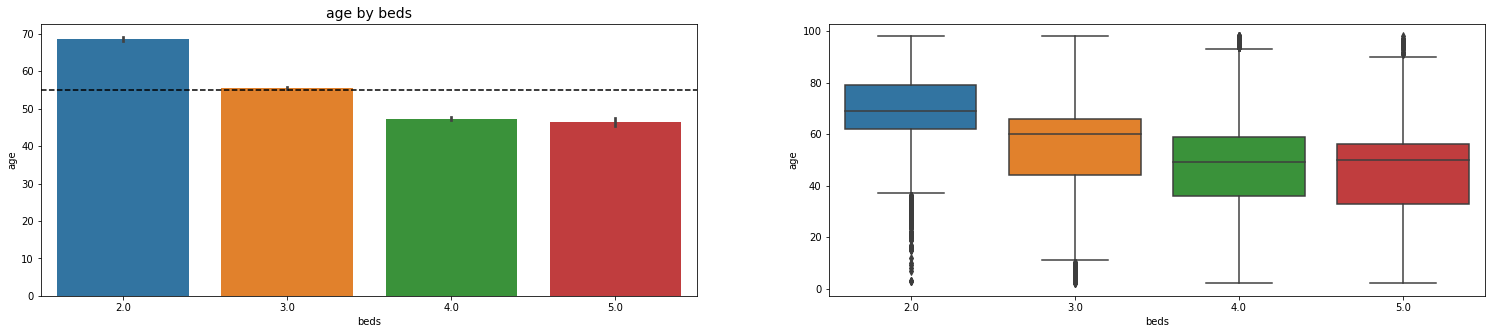

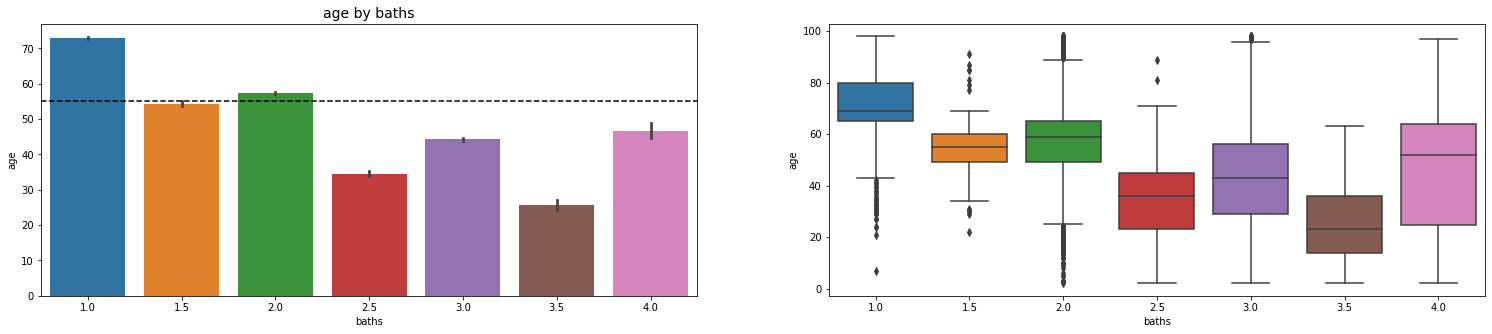

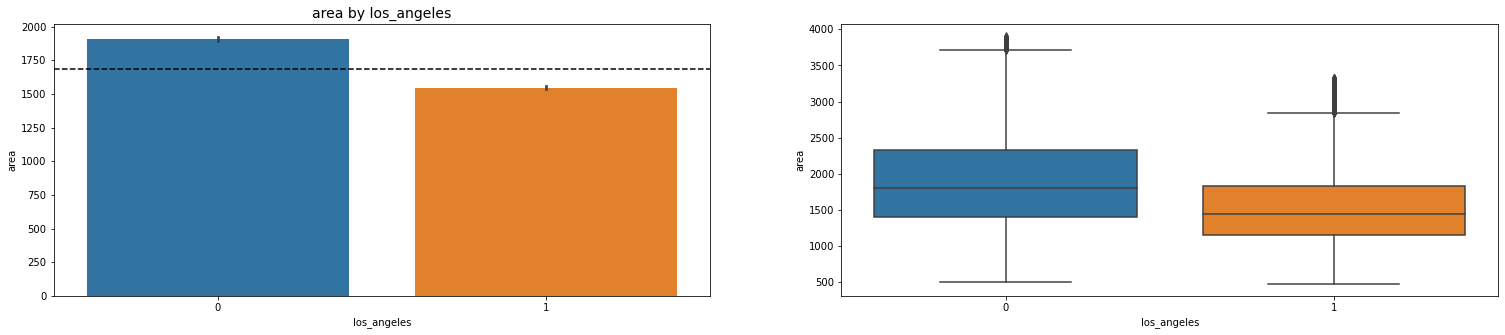

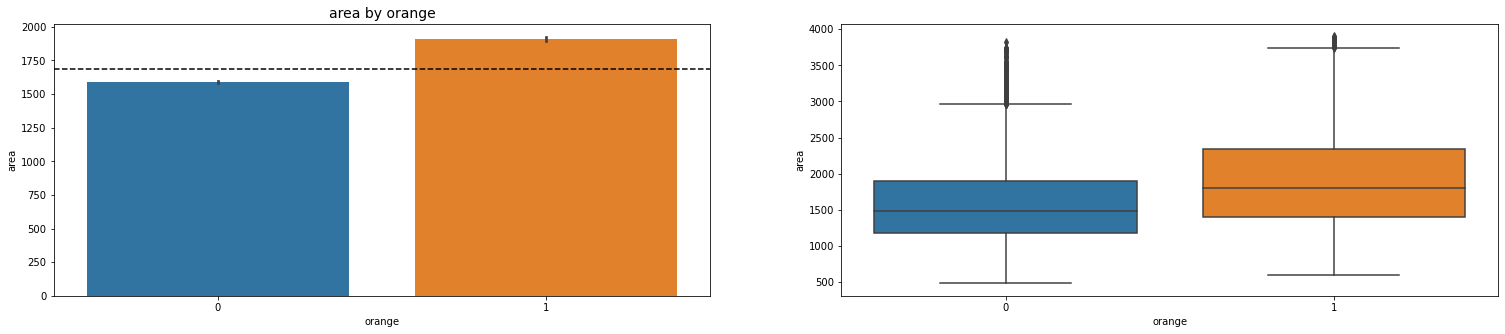

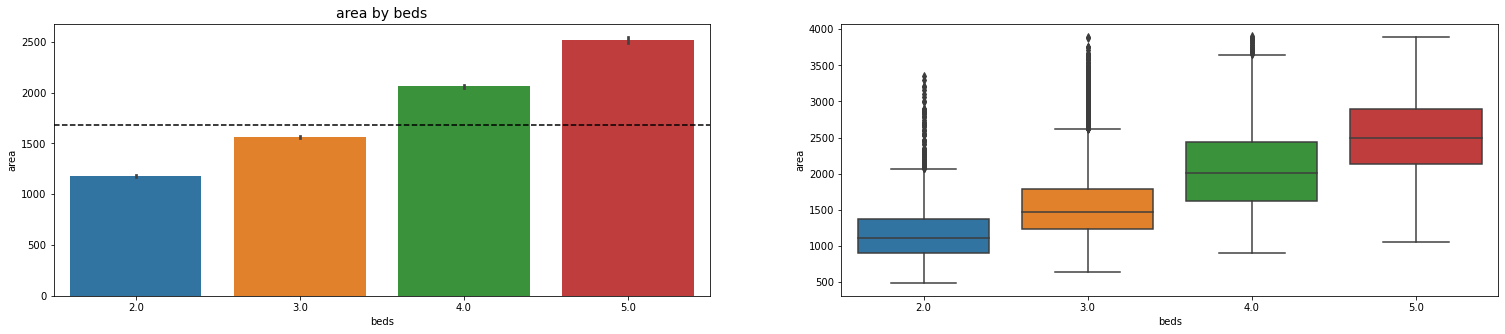

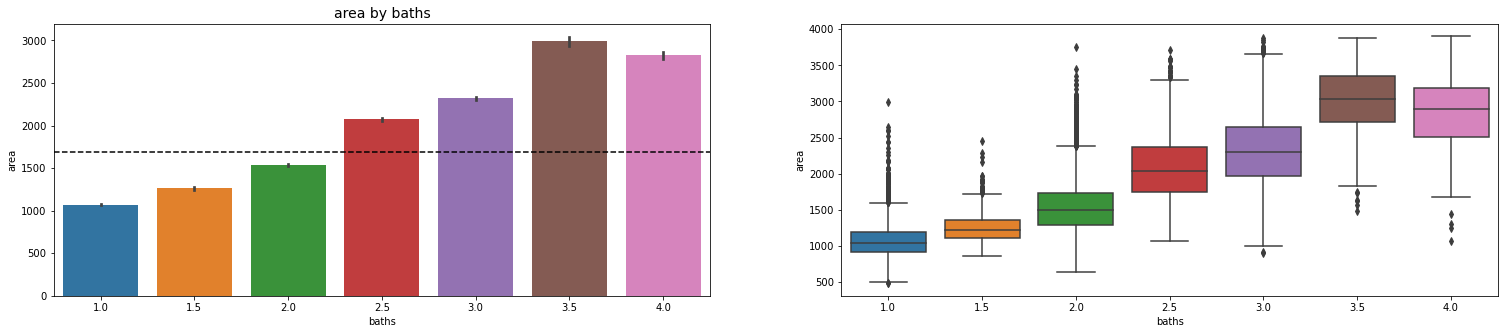

In [35]:

def plot_categorical_and_continuous_vars(train, categ_vars, cont_vars):
    cats = ['los_angeles', 'orange', 'beds', 'baths']
    quant_dogs = ['tax_value', 'age', 'area']
    for dog in quant_dogs:
        for cat in cats:

            plt.figure(figsize=(40,5))
            
            # barplot of average values
            plt.subplot(131)
            sns.barplot(data=train,
                        x=cat,
                        y=dog)
            plt.axhline(train[dog].mean(), 
                        ls='--', 
                        color='black')
            plt.title(f'{dog} by {cat}', fontsize=14)
            
            # box plot of distributions
            plt.subplot(132)
            sns.boxplot(data=train,
                          x=cat,
                          y=dog)
            
            plt.show()

plot_categorical_and_continuous_vars(train, cats, quant_dogs)

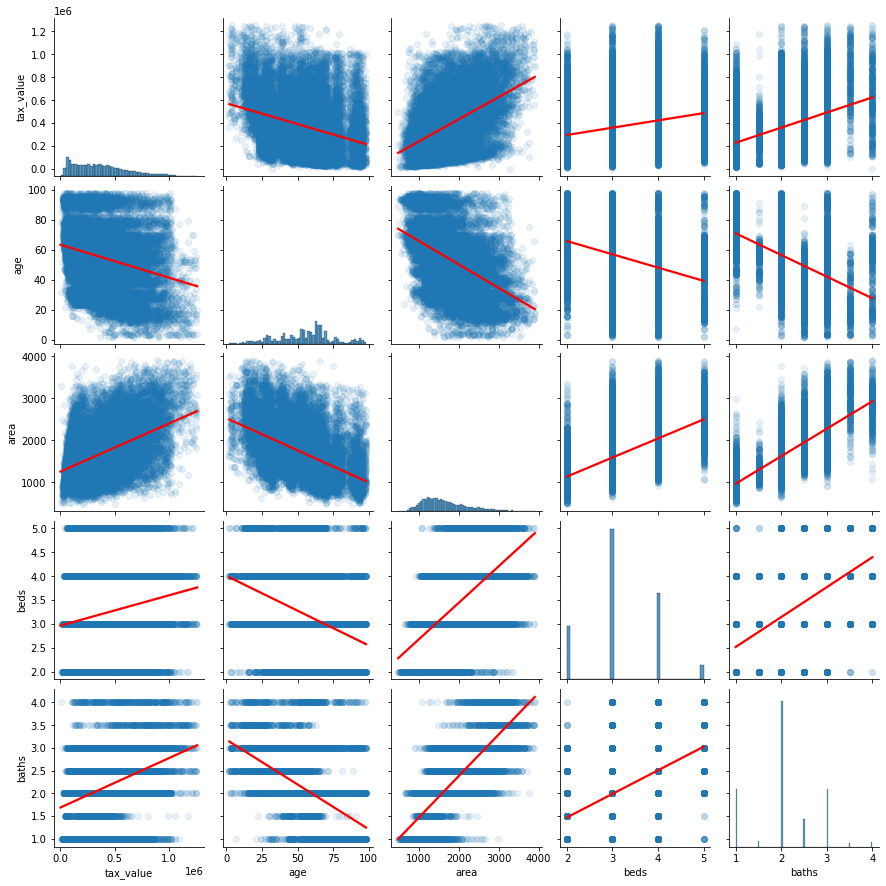

In [92]:
import itertools

quant_dogs = ['tax_value', 'age', 'area', 'beds', 'baths']

#def plot_variable_pairs(train, features):
#    feature_combos = list(itertools.combinations(features, 2))
#    for combo in feature_combos:
#        sns.lmplot(x=combo[0], y=combo[1], data=train, line_kws={'color': 'red'})
#        plot_kws={'line_kws':{'color':'red'}, 'scatter_kws': {'alpha': 0.7}}
#        sns.pairplot(train[cols], hue=hue, kind="reg",plot_kws={'line_kws':{'color':'red'}, 'scatter_kws': {'alpha': 0.1}})
#        plt.show()
#        
#plot_variable_pairs(train, quant_dogs)

def plot_variable_pairs(train, cols, hue=None):
    '''
    This function takes in a df, a list of cols to plot, and default hue=None 
    and displays a pairplot with a red regression line.
    '''
    plot_kws={'line_kws':{'color':'red'}, 'scatter_kws': {'alpha': 0.7}}
    sns.pairplot(train[cols], hue=hue, kind="reg",plot_kws={'line_kws':{'color':'red'}, 'scatter_kws': {'alpha': 0.1}})
    plt.show()
    
plot_variable_pairs(train, quant_dogs)

In [58]:
def plot_variable_pairs(train, hue=None):
    '''
    This function takes in a df, a list of cols to plot, and default hue=None 
    and displays a pairplot with a red regression line.
    '''
    cols = ['tax_value', 'age', 'area', 'beds', 'baths']
    plot_kws={'line_kws':{'color':'red'}, 'scatter_kws': {'alpha': 0.7}}
    sns.pairplot(train[cols], hue=hue, kind="reg",plot_kws={'line_kws':{'color':'red'}, 'scatter_kws': {'alpha': 0.1}})
    plt.show()

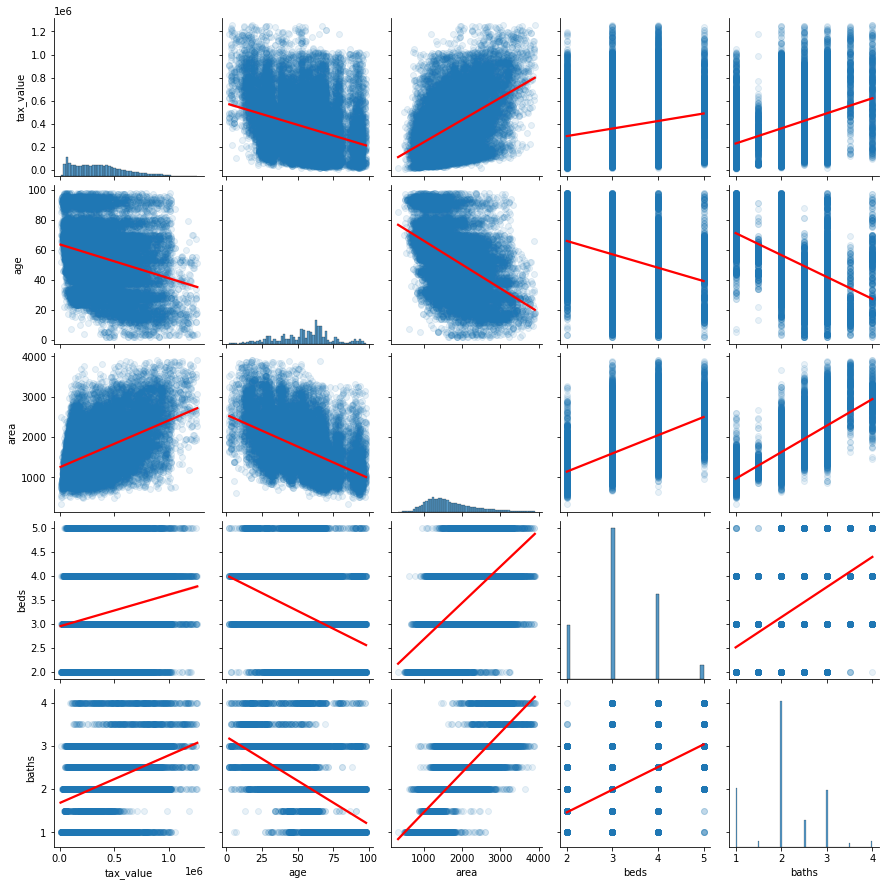

In [59]:
plot_variable_pairs(train)

In [41]:
def tax_correlations(train):
    '''
    Receives the zillow train sample, then uses pandas creates a
    heatmap of the correlations among quantitative features and target. 
    Is also used for X_train_scaled. 
    '''
    # establish figure size
    plt.figure(figsize=(6,6))
    # create the heatmap using the correlation dataframe created above
    heatmap = sns.heatmap(train.corr(), cmap='Purples', annot=True)
    # establish a plot title
    plt.title('Correlations')
    # display the plot
    plt.show()
    
    # visualize predictors' correlation with the target variable 
    plt.figure(figsize=(9,9))
    plt.ylabel('Correlation')
    plt.title('Correlation of features with target of tax_value')
    train.corr().tax_value.sort_values(ascending=False).plot(kind='bar', figsize=(9,9))
    
        # establish figure size
    plt.figure(figsize=(6,6))
    # creat the heatmap using the correlation dataframe created above
    heatmap = sns.heatmap(train.corr()[['tax_value']].sort_values(by='tax_value', ascending=False), vmin=-.5, vmax=.5, annot=True,cmap='flare')
    # establish a plot title
    plt.title('Features Correlated with Tax Value')
    # display the plot
    plt.show()

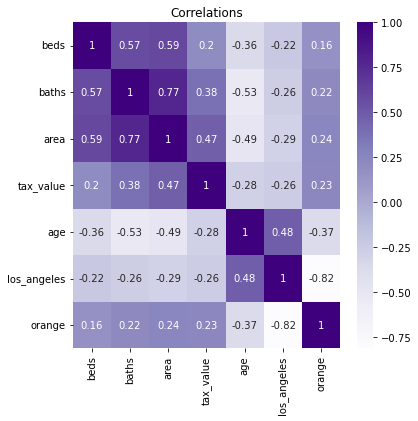

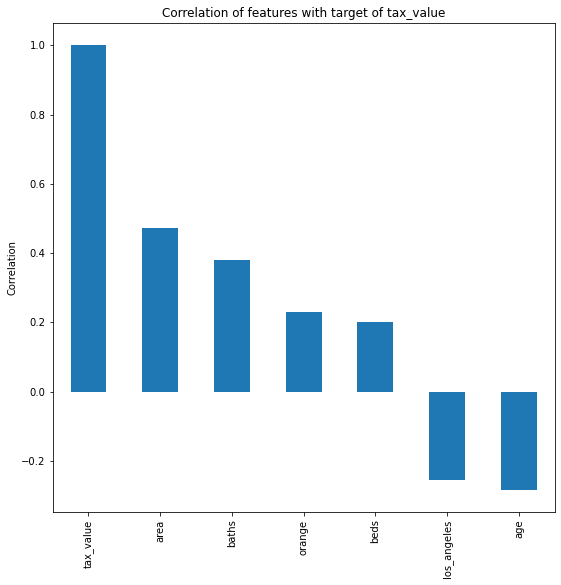

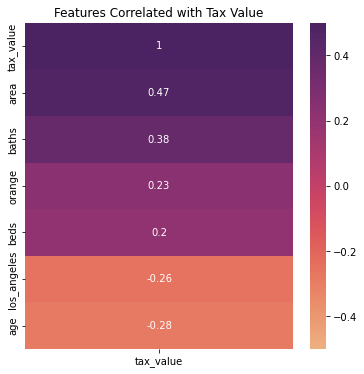

In [43]:
tax_correlations(train)

Area and baths have the highest correlations, although neither of them hit the .5 used to indicate moderate correlation. The magnitude among all these is low. 
Nevertheless, it surprises me that LA has a negative correlation with tax value. It does make up over 60% of the train dataframe, though, which may be why. 

In [ ]:
train_scaled_df

In [79]:
def explore_multivariate(train, target, cat_vars, quant_dogs):
    '''
    This function takes in takes in a dataframe, the name of the binary target variable, a list of 
    the names of the categorical variables and a list of the names of the quantitative variables.
    It generates boxplots showing the target variable for each class of the categorical variables 
    against the quantitative variables.
    '''
    for cat in cat_vars:
        for dog in quant_dogs:
            sns.lmplot(x=dog, y=target, data=train, scatter=True, hue=cat, palette ='muted')
            plt.xlabel(dog)
            plt.ylabel(target)
            plt.title(dog + ' vs ' + target + ' by ' + cat)
            plt.show()

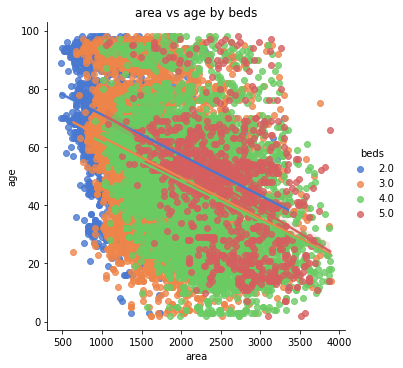

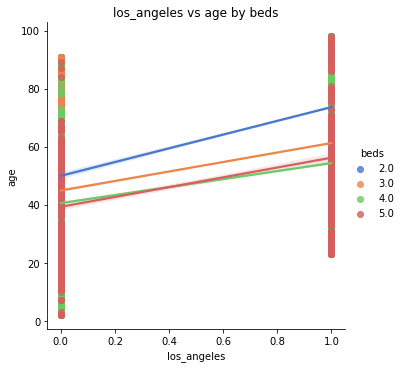

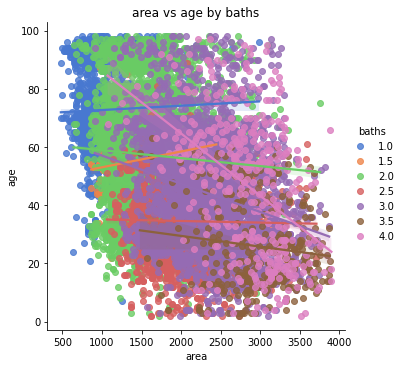

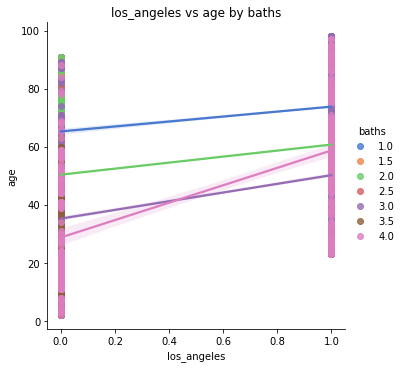

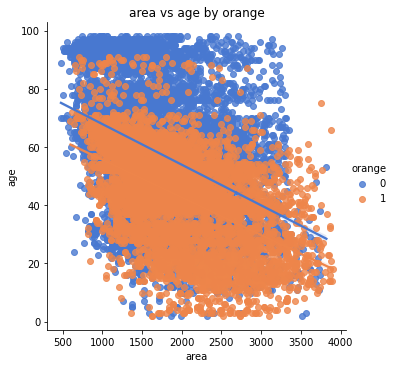

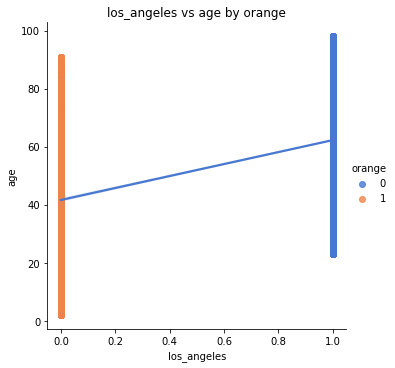

In [84]:
cats = ['beds', 'baths', 'orange']
quant_dogs = ['area', 'los_angeles']
explore_multivariate(train, 'age', cats, quant_dogs)

In [ ]:
# Hideous and useless. 
# Not really. It does tell me that age is associated with number of beds, baths, and thus value. Older homes are smaller. Especially those 60 years and beyond. 

In [ ]:
train

In [105]:
import mitosheet
mitosheet.sheet(train, view_df=True)

MitoWidget(analysis_data_json='{"analysisName": "UUID-55a29b2b-8fda-47cf-a930-fbb30f715ccf", "code": {"imports…

In [56]:
import plotly.express as px

# Filter the dataframe so that it does not crash the browser
train_filtered = train.head(1000)

# Construct the graph and style it. Further customize your graph by editing this code.
# See Plotly Documentation for help: https://plotly.com/python/plotly-express/
fig = px.strip(train_filtered, x='baths', y='age')
fig.update_layout(
    title='baths, age (first 1000 rows) strip',
    xaxis=dict(
        rangeslider=dict(
            visible=True,
            thickness=.05
        )
    )
)
fig.show(renderer="iframe")

In [61]:
import plotly.express as px

# Filter the dataframe so that it does not crash the browser
train_filtered = train.copy()

# Construct the graph and style it. Further customize your graph by editing this code.
# See Plotly Documentation for help: https://plotly.com/python/plotly-express/
fig = px.density_contour(train_filtered, x='age', y='area')
fig.update_layout(
    title='age, area  density contour',
    xaxis=dict(
        rangeslider=dict(
            visible=True,
            thickness=.05
        )
    )
)
fig.show(renderer="iframe")

In [ ]:
train

In [103]:
import mitosheet
mitosheet.sheet(train, view_df=True)

MitoWidget(analysis_data_json='{"analysisName": "UUID-7a9fc3ee-c151-492f-9377-2d5d5b4d5977", "code": {"imports…

In [58]:
from mitosheet import *
# Drop duplicates in train
train = train.drop_duplicates(keep=False)

# Pivoted train into df2
unused_columns = train.columns.difference(set(['beds']).union(set(['baths'])).union(set({'baths'})))
tmp_df = train.drop(unused_columns, axis=1)
pivot_table = tmp_df.pivot_table(
    index=['beds'],
    columns=['baths'],
    values=['baths'],
    aggfunc={'baths': ['count']}
)
pivot_table.set_axis([flatten_column_header(col) for col in pivot_table.keys()], axis=1, inplace=True)
train_pivot = pivot_table.reset_index()

In [59]:
train_pivot

,beds,baths count 1.0,baths count 1.5,baths count 2.0,baths count 2.5,baths count 3.0,baths count 3.5,baths count 4.0
0,2.0,2459,118,1275,115,114,6,2
1,3.0,1903,293,6973,993,1368,79,82
2,4.0,80,62,2891,928,2373,183,189
3,5.0,12,3,152,95,621,72,145


In [98]:
def show_heatmap(train):
    # Filter the dataframe so that it does not crash the browser
    train_filtered = train.copy()
    
    # Construct the graph and style it. Further customize your graph by editing this code.
    # See Plotly Documentation for help: https://plotly.com/python/plotly-express/
    fig = px.density_heatmap(train_filtered, x='tax_value', y='age')
    fig.update_layout(
        title='tax_value, age density heatmap',
        xaxis=dict(
            rangeslider=dict(
                visible=True,
                thickness=.05
            )
        )
    )
    fig.show(renderer="iframe")
    
        # See Plotly Documentation for help: https://plotly.com/python/plotly-express/
    fig = px.density_contour(train_filtered, x='tax_value', y='age')
    fig.update_layout(
        title='tax_value, age density contour',
        xaxis=dict(
            rangeslider=dict(
                visible=True,
                thickness=.05
            )
        )
    )
    fig.show(renderer="iframe")

In [99]:
show_heatmap(train)

In [96]:
def show_contour(train):
    # Filter the dataframe so that it does not crash the browser
    train_filtered = train.copy()
    
    # Construct the graph and style it. Further customize your graph by editing this code.
    # See Plotly Documentation for help: https://plotly.com/python/plotly-express/
    fig = px.density_contour(train_filtered, x='tax_value', y='age')
    fig.update_layout(
        title='tax_value, age density contour',
        xaxis=dict(
            rangeslider=dict(
                visible=True,
                thickness=.05
            )
        )
    )
    fig.show(renderer="iframe")

In [97]:
show_contour(train)

In [100]:
def show_maps_age_area(train):  
    # Filter the dataframe so that it does not crash the browser
    train_filtered = train.copy()
    
    # Construct the graph and style it. Further customize your graph by editing this code.
    # See Plotly Documentation for help: https://plotly.com/python/plotly-express/
    fig = px.density_contour(train_filtered, x='age', y='area')
    fig.update_layout(
        title='age, area  density contour',
        xaxis=dict(
            rangeslider=dict(
                visible=True,
                thickness=.05
            )
        )
    )
    fig.show(renderer="iframe")
    

    # Filter the dataframe so that it does not crash the browser
    train_filtered = train.head(1000)
    
    # Construct the graph and style it. Further customize your graph by editing this code.
    # See Plotly Documentation for help: https://plotly.com/python/plotly-express/
    fig = px.density_heatmap(train_filtered, x='area', y='age')
    fig.update_layout(
        title='area, age (first 1000 rows) density heatmap',
        xaxis=dict(
            rangeslider=dict(
                visible=True,
                thickness=.05
            )
        )
    )
    fig.show(renderer="iframe")

In [101]:
show_maps_age_area(train)

In [106]:
def baths_and_age(train):

    # Construct the graph and style it. Further customize your graph by editing this code.
    # See Plotly Documentation for help: https://plotly.com/python/plotly-express/
    fig = px.strip(train, x='baths', y='age')
    fig.update_layout(
        title='baths, age strip',
        xaxis=dict(
            rangeslider=dict(
                visible=True,
                thickness=.05
            )
        )
    )
    fig.show(renderer="iframe")

    # Construct the graph and style it. Further customize your graph by editing this code.
    # See Plotly Documentation for help: https://plotly.com/python/plotly-express/
    fig = px.violin(train, x='baths', y='age')
    fig.update_layout(
        title='baths, age violin',
        xaxis=dict(
            rangeslider=dict(
                visible=True,
                thickness=.05
            )
        )
    )
    fig.show(renderer="iframe")

In [107]:
baths_and_age(train)

In [115]:
def explore_multivariate(train):
    '''
    This function takes in takes in a dataframe, the name of the binary target variable, a list of 
    the names of the categorical variables and a list of the names of the quantitative variables.
    It generates boxplots showing the target variable for each class of the categorical variables 
    against the quantitative variables.
    '''
    cat_vars = ['beds', 'baths', 'orange']
    quant_dogs = ['area', 'los_angeles']
    for cat in cat_vars:
        for dog in quant_dogs:
            sns.lmplot(x=dog, y='age', data=train, scatter=True, hue=cat, palette ='muted')
            plt.xlabel(dog)
            plt.ylabel('age')
            plt.title(dog + ' vs ' + 'age' + ' by ' + cat)
            plt.show()

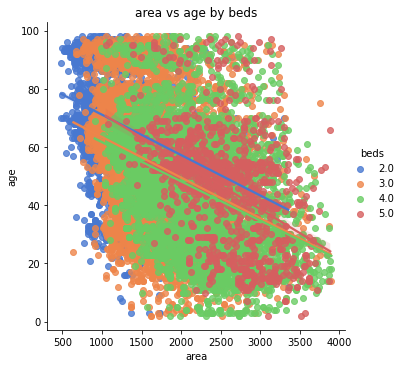

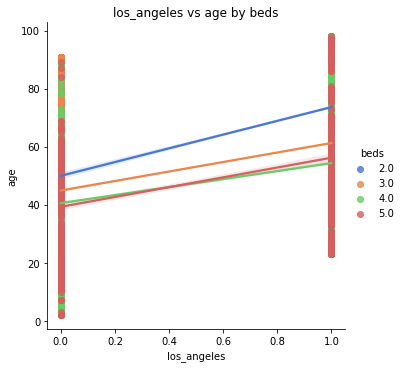

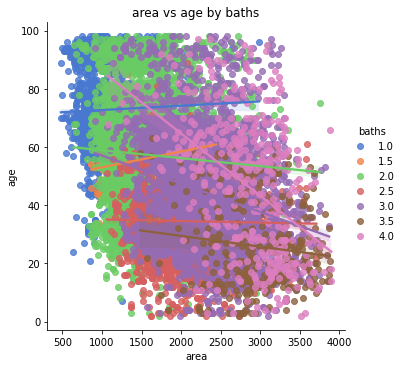

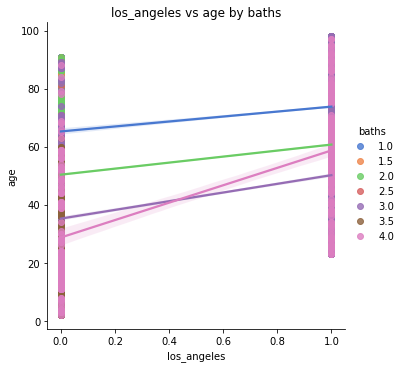

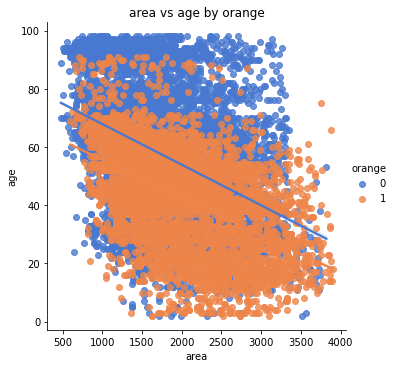

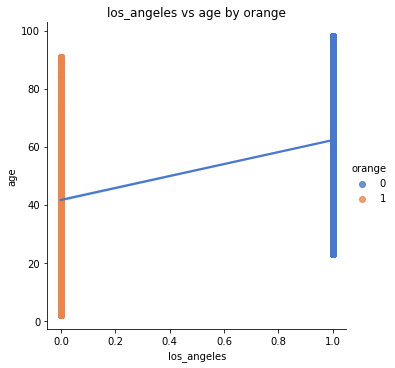

In [116]:
explore_multivariate(train)

In [ ]:
# Gonna try every correlation possibility. 

In [40]:
import scipy.stats as stats
def correlation_test(data_for_category_1, data_for_category_2, alpha=.01):
    '''
    This function takes in data for two variables and performs a pearsons r statistitical test for correlation. 
    It outputs to the console values for r and p and compares them to a given alpha value, then outputs to the 
    console whether or not to reject the null hypothesis based on that comparison. 
    '''
    # display hypotheses
    print(f'H0: There is no linear correlation between {data_for_category_1.name} and {data_for_category_2.name}.')
    print(f'H1: There is a linear correlation between {data_for_category_1.name} and {data_for_category_2.name}.')
    # conduct the stats test and store values for p and r
    r, p = stats.spearmanr(data_for_category_1, data_for_category_2)
    # display the p and r values
    print('\nr = ', round(r, 2))
    print('p = ', round(p, 3))
    # compare p to alpha, display whether to reject the null hypothesis
    if p < alpha:
        print('\nReject H0')
    else:
        print('\nFail to Reject H0')

In [41]:
print(' \n testing area in relation to each \n')
correlation_test(train.area, train.tax_value)
print('')
correlation_test(train.area, train.baths)
print('')
correlation_test(train.area, train.beds)
print('')
correlation_test(train.area, train.los_angeles)
print('')
correlation_test(train.area, train.orange)
print('')
correlation_test(train.area, train.age)
print(' \n testing age in relation to each \n')
correlation_test(train.age, train.beds)
print('')
correlation_test(train.age, train.baths)
print('')
correlation_test(train.age, train.tax_value)
print('')
correlation_test(train.age, train.los_angeles)
print('')
correlation_test(train.age, train.orange)
print('')
correlation_test(train.age, train.baths)
print(' \n testing beds in relation to each \n')
correlation_test(train.beds, train.baths)
print('')
correlation_test(train.beds, train.tax_value)
print('')
correlation_test(train.beds, train.los_angeles)
print('')
correlation_test(train.beds, train.orange)
print(' \n testing baths in relation to each \n')
correlation_test(train.baths, train.tax_value)
print('')
correlation_test(train.baths, train.los_angeles)
print('')
correlation_test(train.baths, train.orange)
print(' \n testing tax value in relation to each \n')
correlation_test(train.tax_value, train.los_angeles)
print('')
correlation_test(train.tax_value, train.orange)
print('')
print(' \n Final Test')
correlation_test(train.los_angeles, train.orange)

print('Pearsons R would reject in any case even at a .01 alpha')

 
 testing area in relation to each 

H0: There is no linear correlation between area and tax_value.
H1: There is a linear correlation between area and tax_value.

r =  0.41
p =  0.0

Reject H0

H0: There is no linear correlation between area and baths.
H1: There is a linear correlation between area and baths.

r =  0.8
p =  0.0

Reject H0

H0: There is no linear correlation between area and beds.
H1: There is a linear correlation between area and beds.

r =  0.6
p =  0.0

Reject H0

H0: There is no linear correlation between area and los_angeles.
H1: There is a linear correlation between area and los_angeles.

r =  -0.29
p =  0.0

Reject H0

H0: There is no linear correlation between area and orange.
H1: There is a linear correlation between area and orange.

r =  0.23
p =  0.0

Reject H0

H0: There is no linear correlation between area and age.
H1: There is a linear correlation between area and age.

r =  -0.51
p =  0.0

Reject H0
 
 testing age in relation to each 

H0: There is no 

In [ ]:
train

In [15]:
import mitosheet
mitosheet.sheet(train, view_df=True)

MitoWidget(analysis_data_json='{"analysisName": "UUID-084ed907-6627-4811-a1f6-720a7e1e3c3d", "code": {"imports…

In [16]:
train.area.describe()

count    23524.000000
mean      1679.605169
std        602.696776
min        326.000000
25%       1231.000000
50%       1551.000000
75%       2028.000000
max       3901.000000
Name: area, dtype: float64

In [54]:
# t test for area and value, I used 1679 sqft because it is the median area of all selected properties.
# The results suggest they are related to each other.
null_hypothesis = "Values of houses with 1679 sq ft or more, and houses with less square footage independent of home value"
alternative_hypothesis = "Values of houses with 1679 sq ft or more, and houses with less square footage not independent to value of home"
a = 0.01 #a for alpha 

bigger_houses = train[train.area>=1679]
smaller_houses = train[train.area<1679]
t, p = stats.ttest_ind(bigger_houses.tax_value, smaller_houses.tax_value)

if p < a:
    print(f'Reject null hypothesis that: {null_hypothesis}')
else:
    print(f'Fail to reject null hypothesis that: {null_hypothesis} There is not sufficient evidence to reject it.')

Reject null hypothesis that: Values of houses with 1679 sq ft or more, and houses with less square footage independent of home value


In [55]:
# 60 is the mean
# The results suggest there is not much of a difference in value of homes depending on age. 
null_hypothesis = "House age is independent to value of home"
alternative_hypothesis = "A house being 10 years or older, or less than 10 years, have an affect on value"
a = 0.01 #a for alpha 

old_house = train[train.age>=60]
new_house = train[train.age<60]
t, p = stats.ttest_ind(old_house.tax_value, new_house.tax_value)

if p < a:
    print(f'Reject null hypothesis that: {null_hypothesis}')
else:
    print(f'Fail to reject null hypothesis.')

Reject null hypothesis that: House age is independent to value of home


In [57]:
alpha = 0.01
r, p = stats.spearmanr(train.age, train.tax_value)
r, p, alpha

if p < alpha:
    print('''Our p value is less than alpha and we can reject the null hypothesis.
We can suggest there is a linear correlation between age of home and taxvalue''')
else:
    print('We cannot reject the null hypothesis')

Our p value is less than alpha and we can reject the null hypothesis.
We can suggest there is a linear correlation between age of home and taxvalue


In [63]:
def testing_area(train):
    
    # t test for area and value, I used 1679 sqft because it is the median area of all selected properties.
    # The results suggest they are related to each other.
    null_hypothesis = "Median home value 1,679 sq ft, whether increased or decreased, is independent of assessed value."
    alternative_hypothesis = "Median home value 1,679 sq ft, whether increased or decreased, is not independent of assessed value."
    a = 0.01 #a for alpha 

    bigger_houses = train[train.area>=1679]
    smaller_houses = train[train.area<1679]
    t, p = stats.ttest_ind(bigger_houses.tax_value, smaller_houses.tax_value)

    if p < a:
        print(f'Reject null hypothesis that: {null_hypothesis}')
    else:
        print(f'Fail to reject null hypothesis that: {null_hypothesis} There is not sufficient evidence to reject it.')

In [64]:
testing_area(train)

Reject null hypothesis that: Median home value 1,679 sq ft, whether increased or decreased, is independent of assessed value.


In [68]:
def test_age(train): 
    alpha = 0.01
    r, p = stats.spearmanr(train.age, train.tax_value)
    r, p, alpha

    if p < alpha:
        print('''Having successfully rejected the null, a home's value in some way depends on its age ''')
    else:
        print('We cannot reject the null hypothesis')

In [69]:
test_age(train)

Having successfully rejected the null, a home's value in some way depends on its age 


In [76]:
def testing_baths(train):
     # conduct the stats test and store values for p and r
    r, p = stats.spearmanr(train.baths, train.age)
    # display the p and r values
    print('\nr = ', round(r, 2))
    print('p = ', round(p, 3))
    # compare p to alpha, display whether to reject the null hypothesis
    if p < alpha:
        print('\nReject H0')
        print("Thus, number of baths and age have a linear relationship.")
    else:
        print('\nFail to Reject H0')

In [77]:
testing_baths(train)


r =  -0.58
p =  0.0

Reject H0
Thus, number of baths and age have a linear relationship.
